Adapting Grad-CAM for Embedding Networks  
Lei Chen, Jianhui Chen, Hossein Hajimirsadeghi, Greg Mori

see publication https://arxiv.org/pdf/2001.06538.pdf

Code from https://colab.research.google.com/drive/1CJQSVaXG1ceBQGFrTHnt-pt1xjO4KFDe

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import cv2

import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
model = tf.keras.models.load_model("stork_net_v2.h5")

In [3]:
img_dir = pathlib.Path("/Users/stefan_schmutz/Dropbox/stork-net_raw/images/2019_grad-cam/")

img_height = 480
img_width = 640
channels = 3

class_names = np.array(["3_stork", "1_stork", "0_stork", "2_stork"])

In [4]:
# The 1./255 is to convert from uint8 to float32 in range [0,1]
img_generator = ImageDataGenerator(rescale=1./255)

img_data_gen = img_generator.flow_from_directory(batch_size=4,
                                                 directory=img_dir,
                                                 shuffle=False,
                                                 target_size=(img_height, img_width),
                                                 class_mode="categorical",
                                                 classes = [""])

Found 4 images belonging to 1 classes.


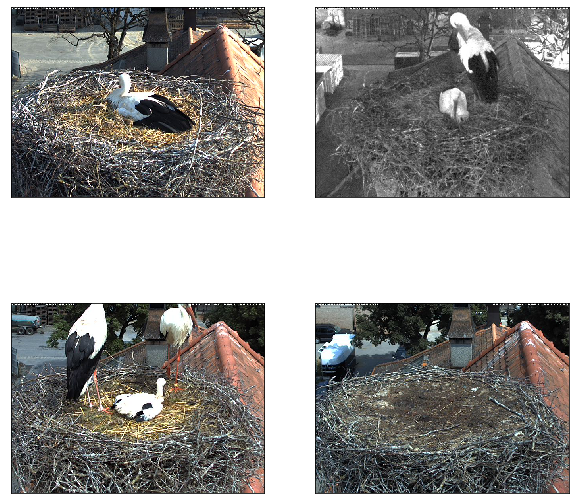

In [5]:
images, _ = next(img_data_gen)

plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

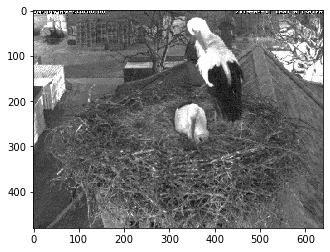

In [6]:
plt.imshow(images[1])
plt.show()

In [7]:
predictions = model.predict(img_data_gen)

# decode one-hot encoded labels
predictions_decoded = tf.argmax(predictions, axis=1)
predictions_label = [class_names[i] for i in predictions_decoded]


predictions_prob = []
for j in range(len(predictions_label)):
    predictions_prob.append(predictions[j, predictions_decoded[j]])

In [8]:
print(predictions_label)
print(predictions_prob)

['1_stork', '2_stork', '2_stork', '0_stork']
[0.8504181, 0.9999913, 0.9999639, 0.99999905]


In [9]:
last_conv_layer_name = "dropout_1"
classifier_layer_names = ["flatten", "dense", "dense_1"]

In [50]:
#get_img_array
array = images[2]
img_array = np.expand_dims(array, axis=0)

#get image prediction
pred = predictions_decoded[2].numpy()

In [51]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
  # First, we create a model that maps the input image to the activations
  # of the last conv layer
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

  # Second, we create a model that maps the activations of the last conv
  # layer to the final class predictions
  classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x)

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

  # This is the gradient of the top predicted class with regard to
  # the output feature map of the last conv layer
  grads = tape.gradient(top_class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
  return heatmap

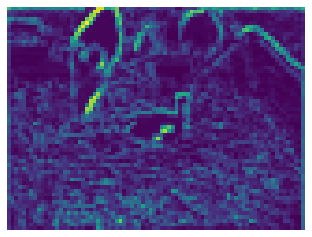

In [53]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

plt.matshow(heatmap)
plt.axis("off")
plt.savefig("2019-05-29_12-35_heatmap.png")
plt.show()


In [35]:
# We use cv2 to load the original image
img = cv2.imread("/Users/stefan_schmutz/Dropbox/stork-net_raw/images/2019_grad-cam/2019-07-27_12-55.jpg")

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
save_path = "2019-07-27_12-55.jpg"
cv2.imwrite(save_path, superimposed_img)

True